# Dev / Library

## Import data from spoon.

In [1]:
import json
def open_json(file_path):
    datastore = {}
    with open(file_path, 'r') as f:
        datastore = json.load(f)
    return datastore

A fonction to get the name of a library according to its definition and the depth.

> 'java.util.ArrayList', depth=2 -> 'java.util'



In [2]:
def import_to_name(library_import, depth):
    return '.'.join(library_import.split('.')[:depth])

Define the mapping of imports to an ids.

In [3]:
def define_mapping(libraries_set, depth): # TODO : Option to keep tree structure
    A = set(sorted([import_to_name(library_import, depth) for library_import in libraries_set]) + ['UNK'])
    length = len(A)
    map_dict = dict(zip(A, range(length)))
    def mapping(import_value):
        name = import_to_name(import_value, depth)
        if name not in A:
            name = 'UNK'
        return map_dict[name]
    return mapping, A, length

In [4]:
# 2 more or less equal to the library level 
data = open_json('spoon_commits.json')
libraries_set = data['libraries_set']
commit_info = data['commit_info']
mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, 2)

Some basic vector operators

In [5]:
def v_sum(*v):
    return tuple([sum(e) for e in zip(*v)])

def z_k(n, *Ks):
    z_k = [0] * n
    for i in Ks:
        z_k[i] = 1
    return tuple(z_k)

Count for every commits the number of time a library was imported in all modified files.

In [6]:
import pandas as pd
data = []

for sha, commit in list(commit_info.items()):
    libraries = set()
    c = z_k(mapping_size)
    for file, file_info in commit['files_info'].items():
        file_libraries = set([ mapping(lib) for lib in file_info['imports'] ])
        libraries = libraries | file_libraries
        c = v_sum(c, z_k(mapping_size, *file_libraries))
    if len(libraries) > 0:
        data.append( [sha, commit['author']['name']] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df = pd.DataFrame(data=data, columns=['sha', 'author', *mapping_elemnts])

Sum the commits by users.

**Then drop the contibutors who has modified 10 file or less. And the libraries imported less than once**

Finally sort the data in row and column by the number of modifications.

In [7]:
def group_duplicate_entry(df, *duplicate_entries):
    for entry1, entry2 in duplicate_entries:
        df.loc[entry1] = df.loc[entry1] + df.loc[entry2]
        df = df.drop(entry2)
    return df

agreg = df.groupby('author').sum()
agreg = agreg.loc[:,agreg.sum() > 1]
#agreg = agreg.loc[agreg.sum(axis=1) > 10]

duplicate_entries = (
    ('Martin Monperrus', 'martin'),
    ('Thomas Durieux', 'tdurieux'),
    ('Nicolas Petitprez', 'petitpre'),
    ('Gérard Paligot', 'GerardPaligot'),
    ('Gérard Paligot', 'Gerard Paligot'),
    ('Roman Leventov', 'leventov'),
    ('Benjamin DANGLOT', 'danglotb'),
    ('Tomasz Zieliński', 'Tomasz Zielinski')
)
agreg = group_duplicate_entry(agreg, *duplicate_entries)

agreg_sorted = agreg.loc[agreg.sum(axis=1).sort_values(ascending=False).index]
agreg_sorted = agreg_sorted.loc[:,agreg_sorted.sum(axis=0).sort_values(ascending=False).index]

## Analysis

In [8]:
import matplotlib.pyplot as plt
import numpy as np

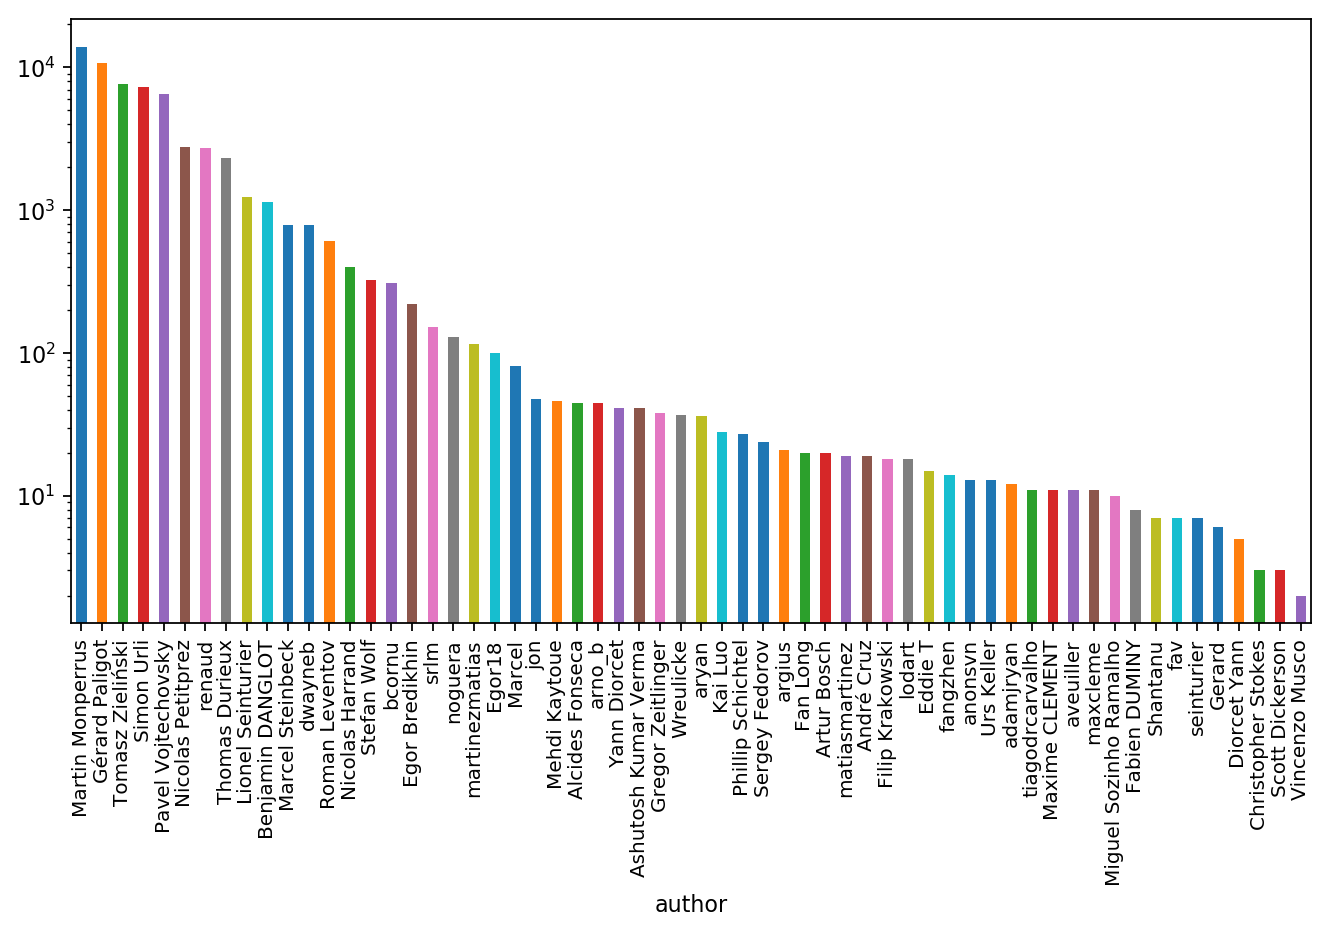

In [9]:
fig = plt.figure(figsize=(10, 5), dpi=160, facecolor='w', edgecolor='k')
number_of_contibs = agreg_sorted.sum(axis=1)
ax = number_of_contibs.plot.bar()
ax.set_yscale('log')
plt.xticks(range(len(list(number_of_contibs.index))), list(number_of_contibs.index), rotation=90, fontsize=9)
plt.show()

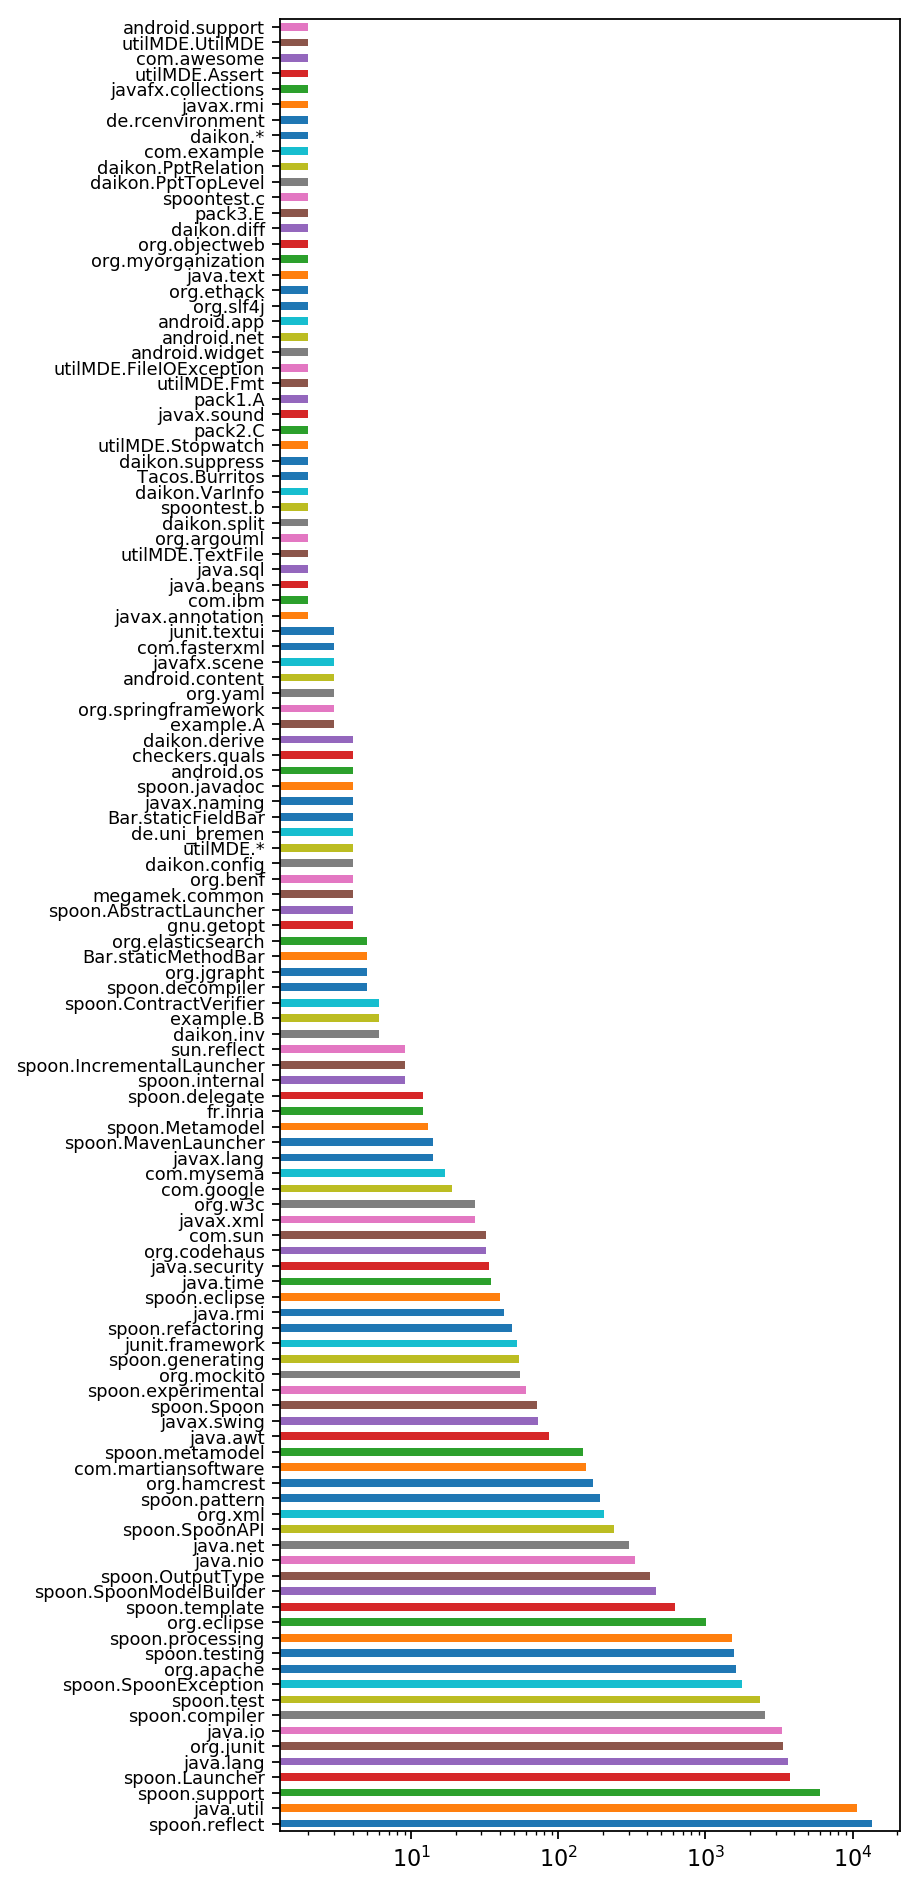

In [10]:
fig = plt.figure(figsize=(5, 15), dpi=160, facecolor='w', edgecolor='k')
number_of_imports = agreg_sorted.sum(axis=0)
ax = number_of_imports.plot.barh()
ax.set_xscale('log')
plt.yticks(range(len(list(number_of_imports.index))), list(number_of_imports.index), fontsize=8)
plt.show()

In [11]:
def plot_matrix(df, title, xlabel = '', ylabel='', log_scale=False):
    fig = plt.figure(figsize=(18, 16), dpi=160, facecolor='w', edgecolor='k')
    if log_scale:
        plt.imshow(np.log(df.add(1)))
    else:
        plt.imshow(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(list(df.columns))), list(df.columns), rotation=90, fontsize=9)
    plt.yticks(range(len(list(df.index))), list(df.index), fontsize=9)
    plt.title(title, fontsize=24)
    #plt.ylabel('some numbers')
    plt.show()

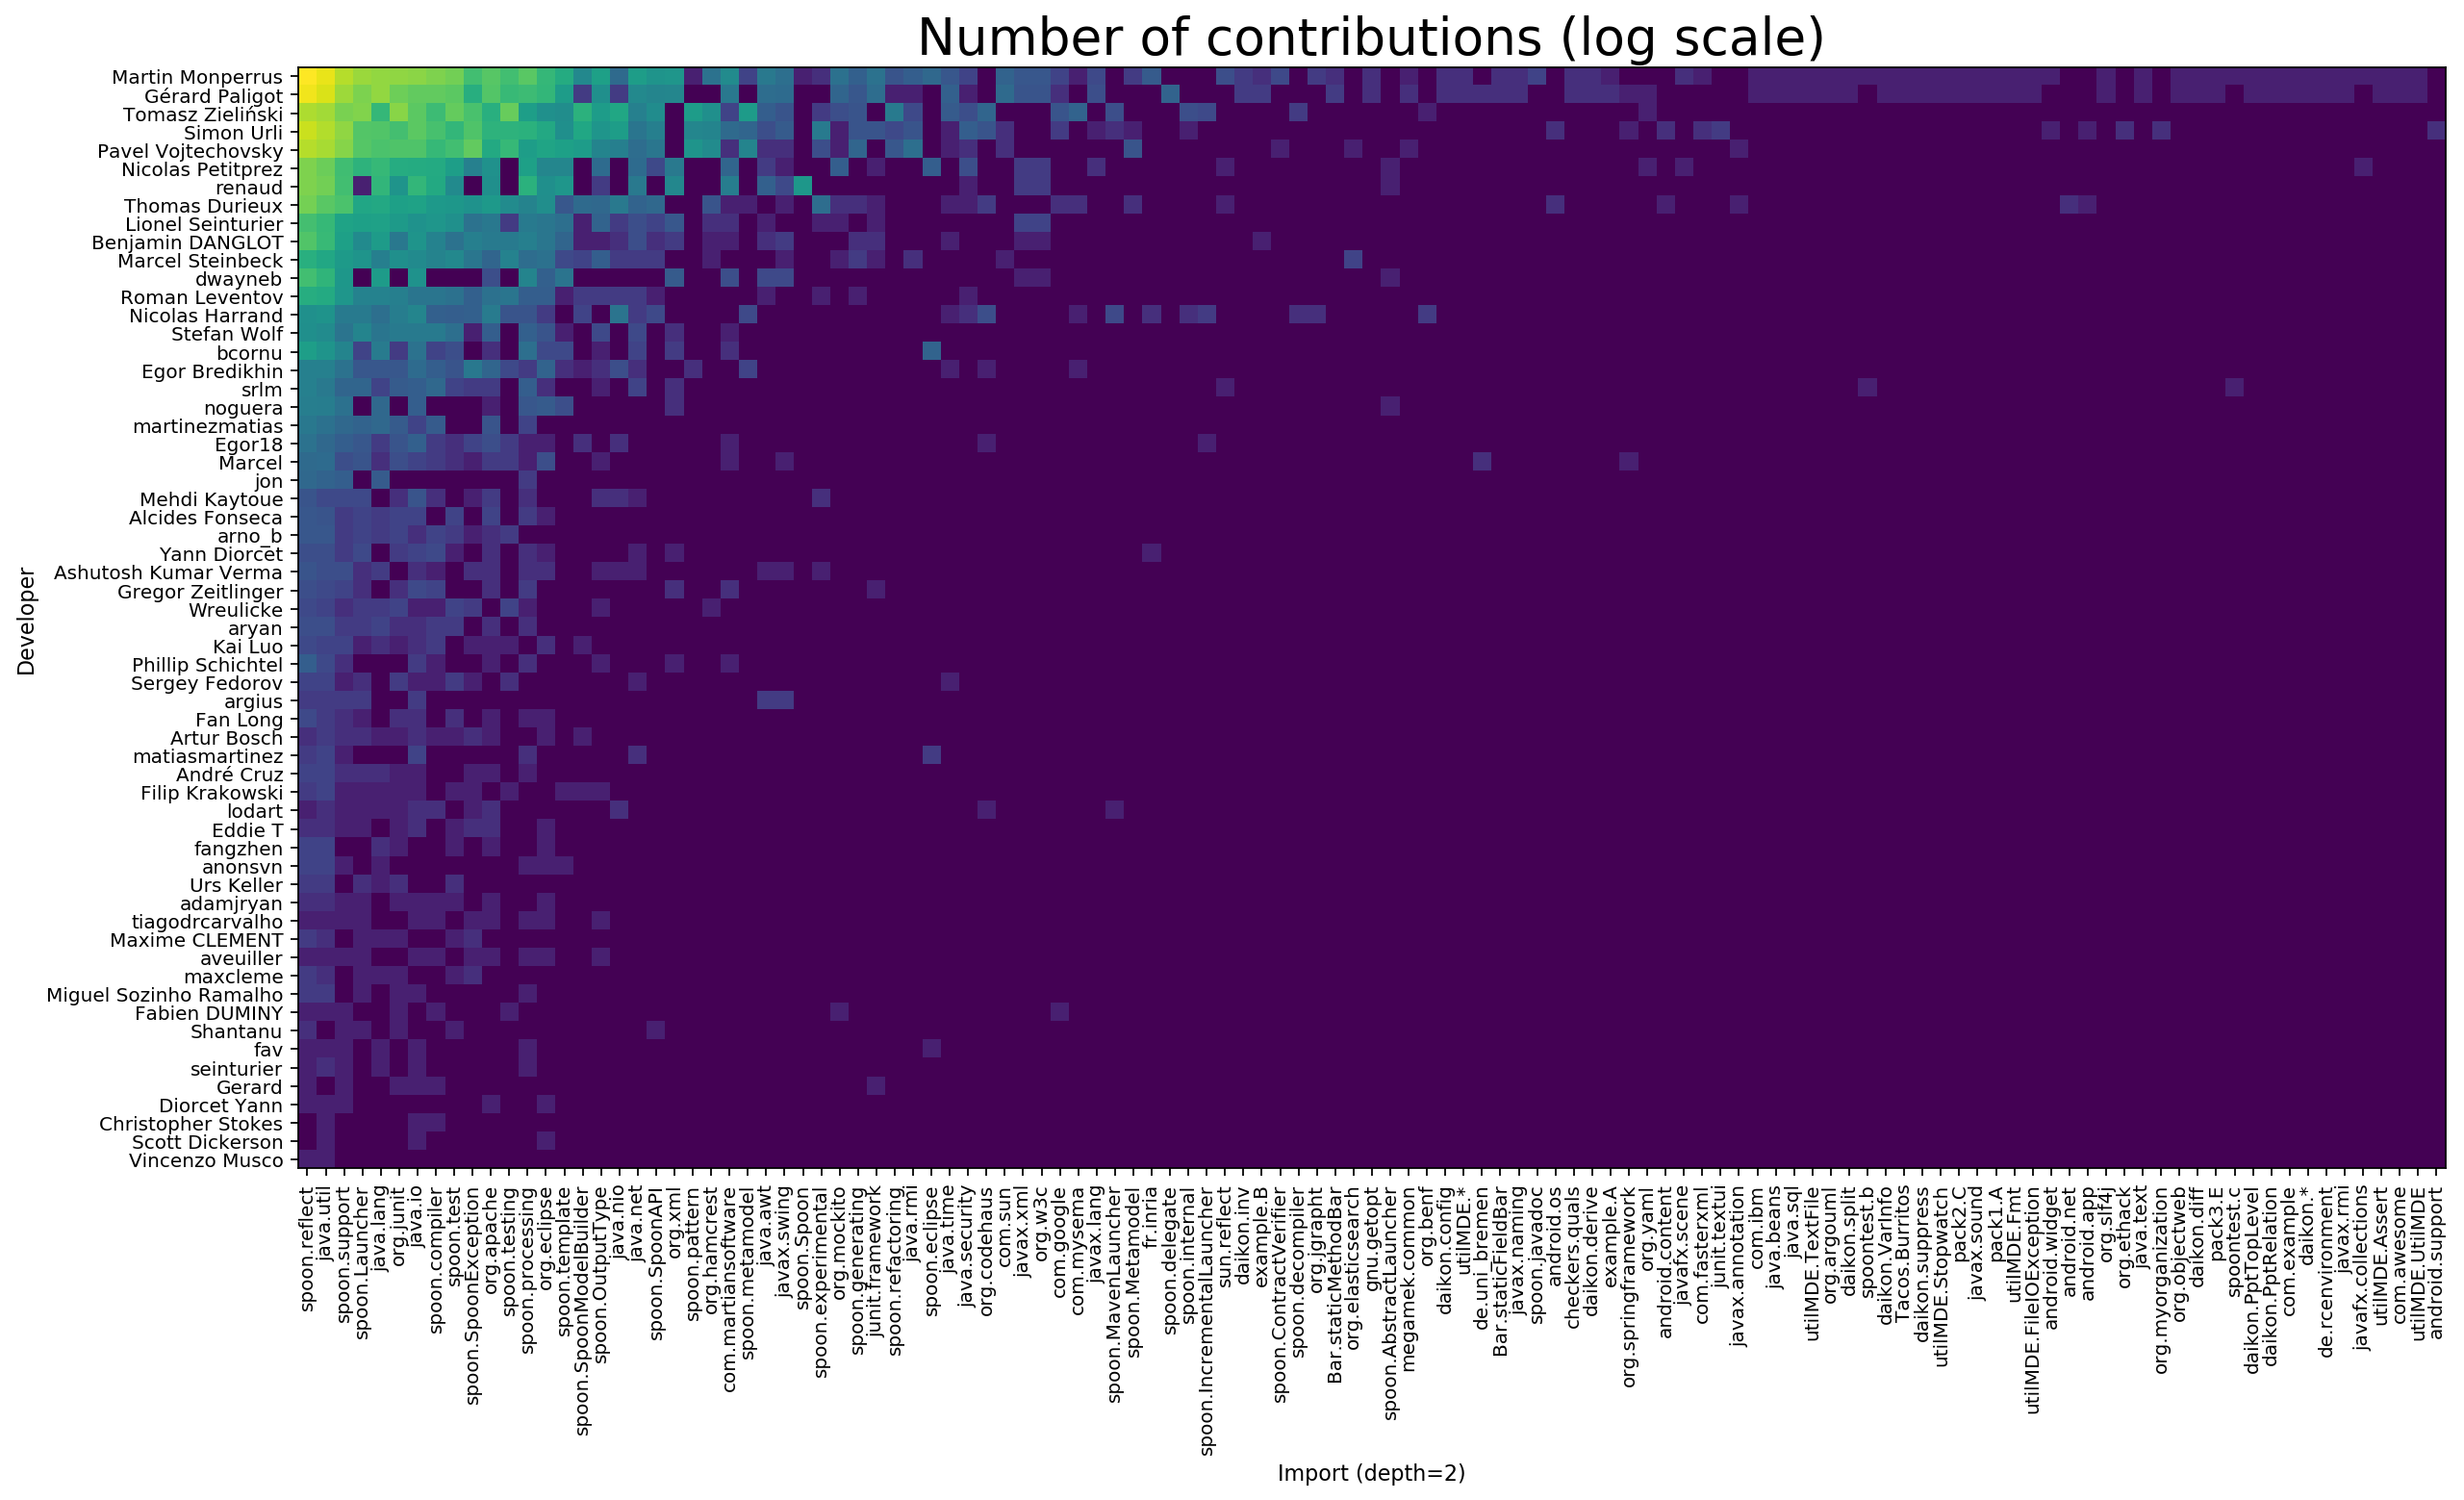

In [12]:
plot_matrix(agreg_sorted, 'Number of contributions (log scale)', xlabel='Import (depth=2)', ylabel='Developer', log_scale=True)

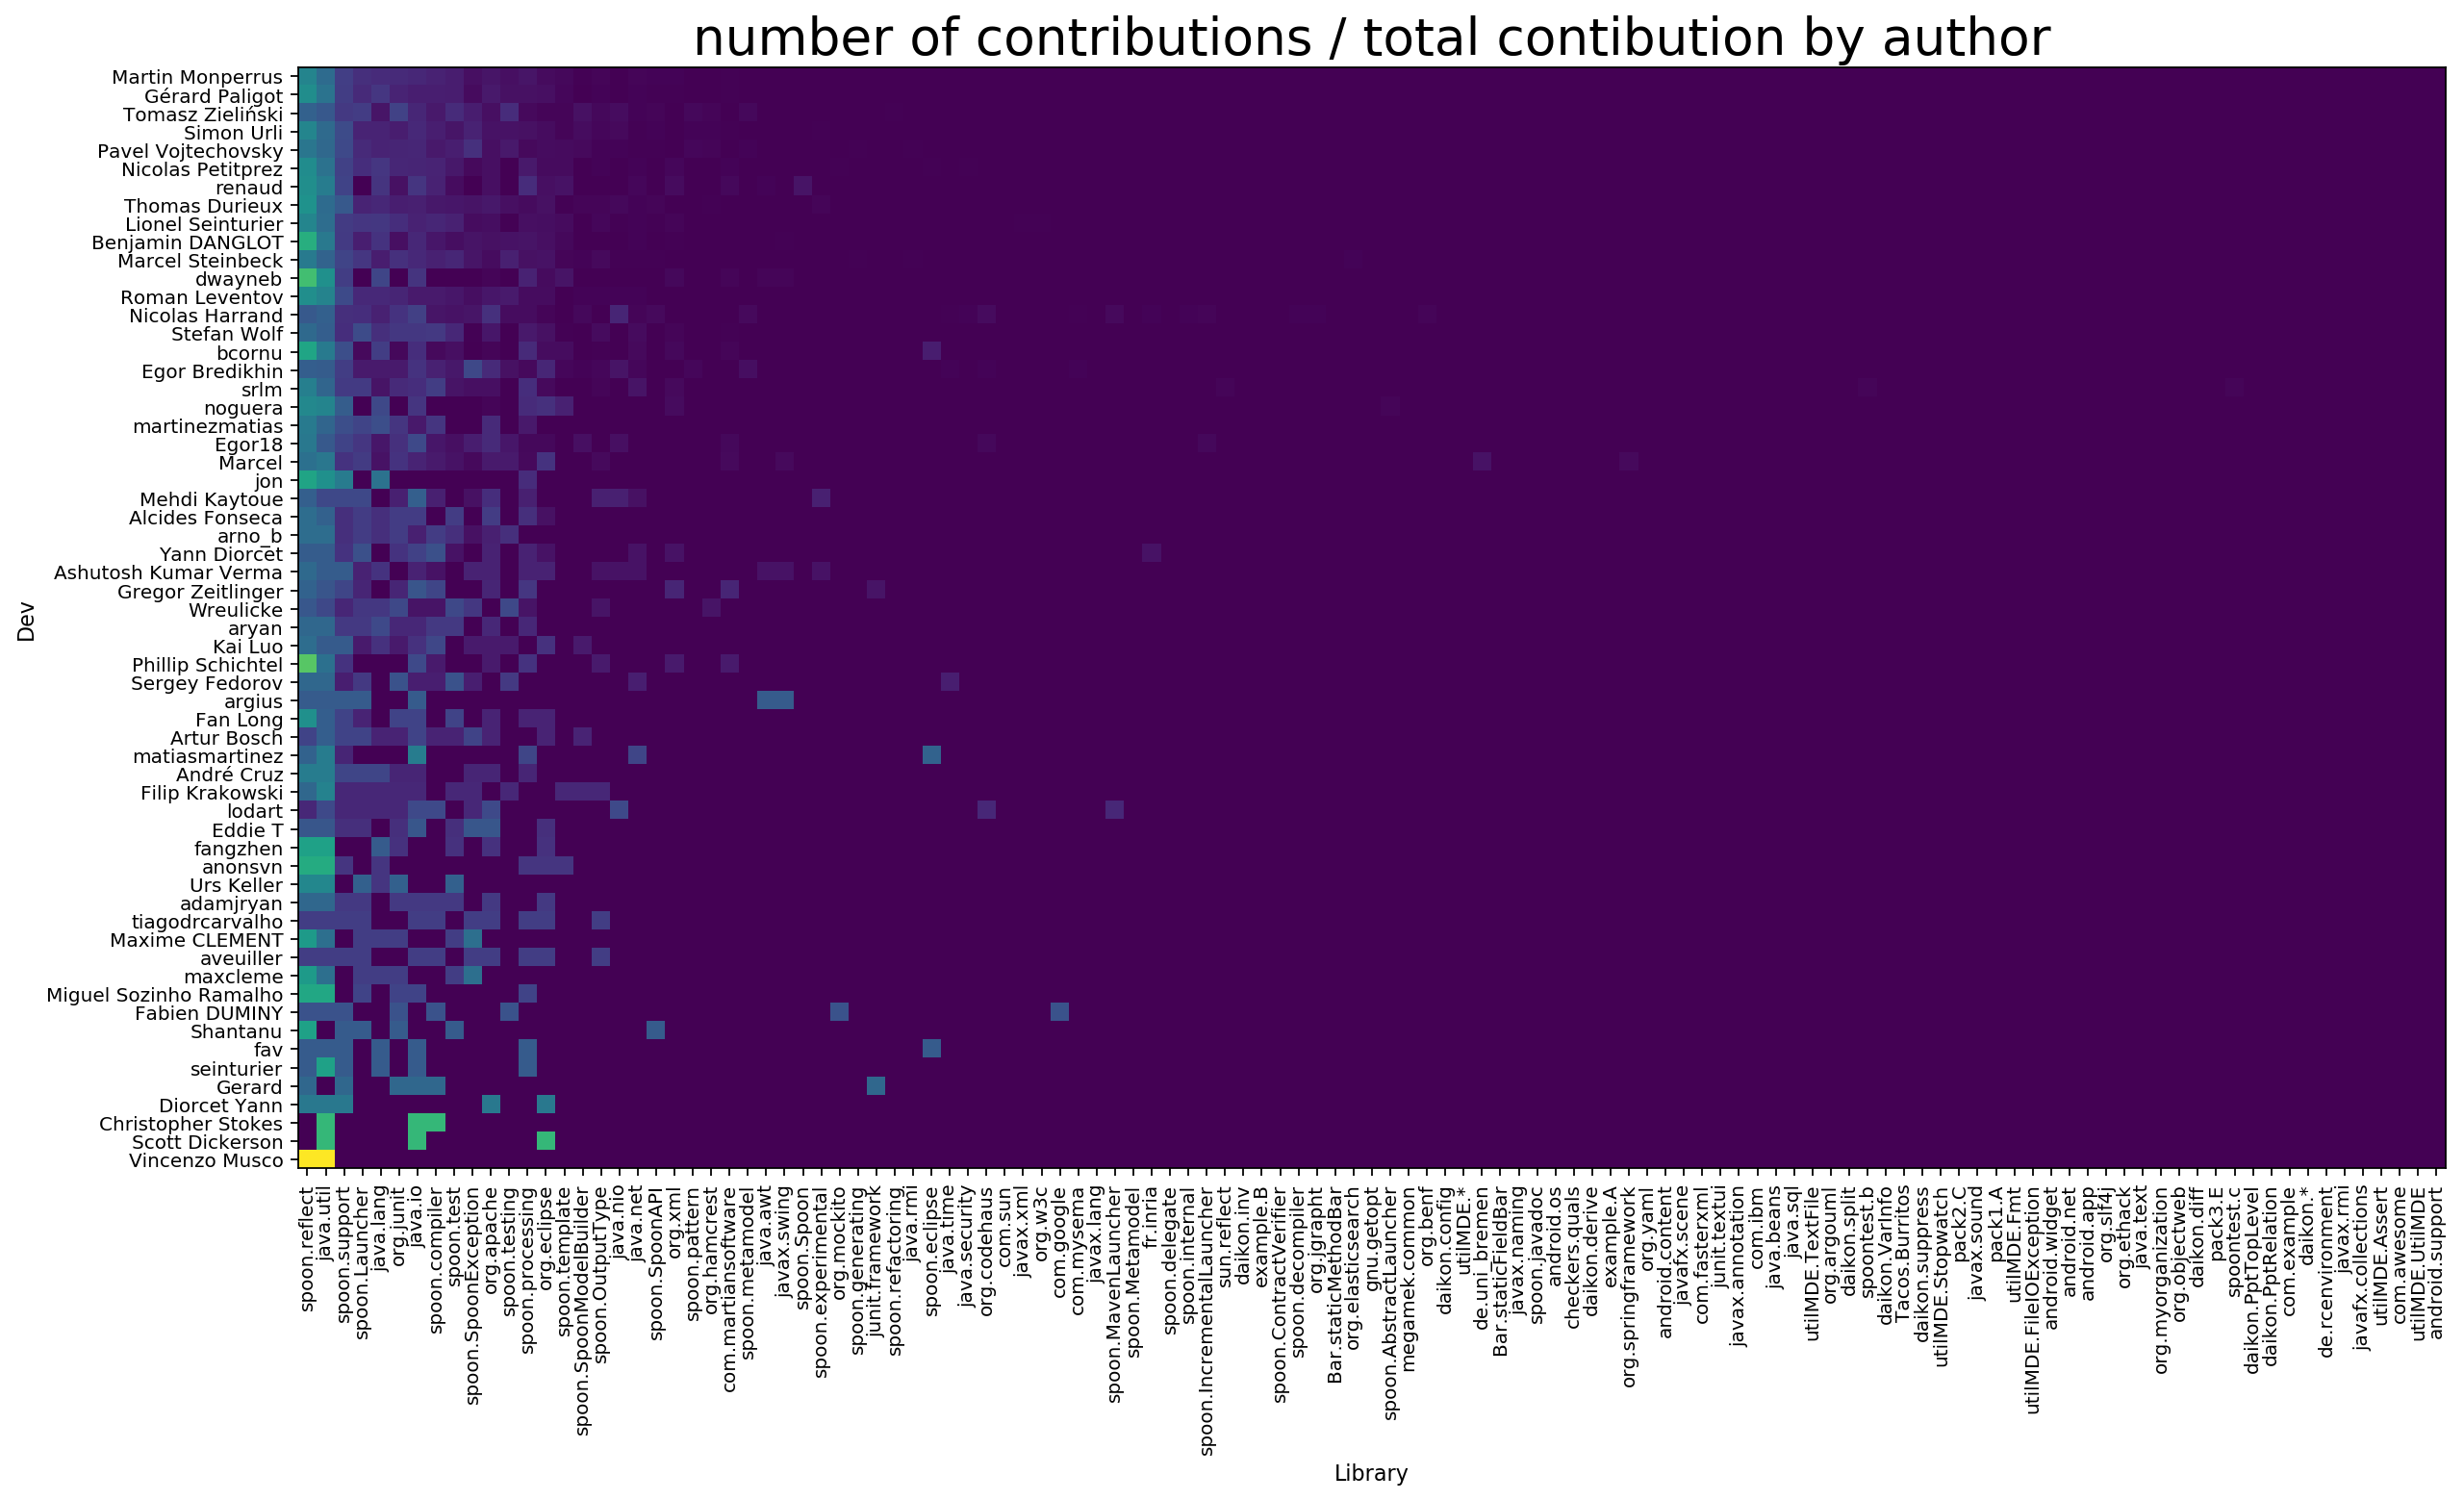

In [13]:
ratio_libcontrib_totcontrib = agreg_sorted.div(agreg_sorted.sum(axis=1), axis = 0)
plot_matrix(ratio_libcontrib_totcontrib, 'number of contributions / total contibution by author', xlabel='Library', ylabel='Dev')

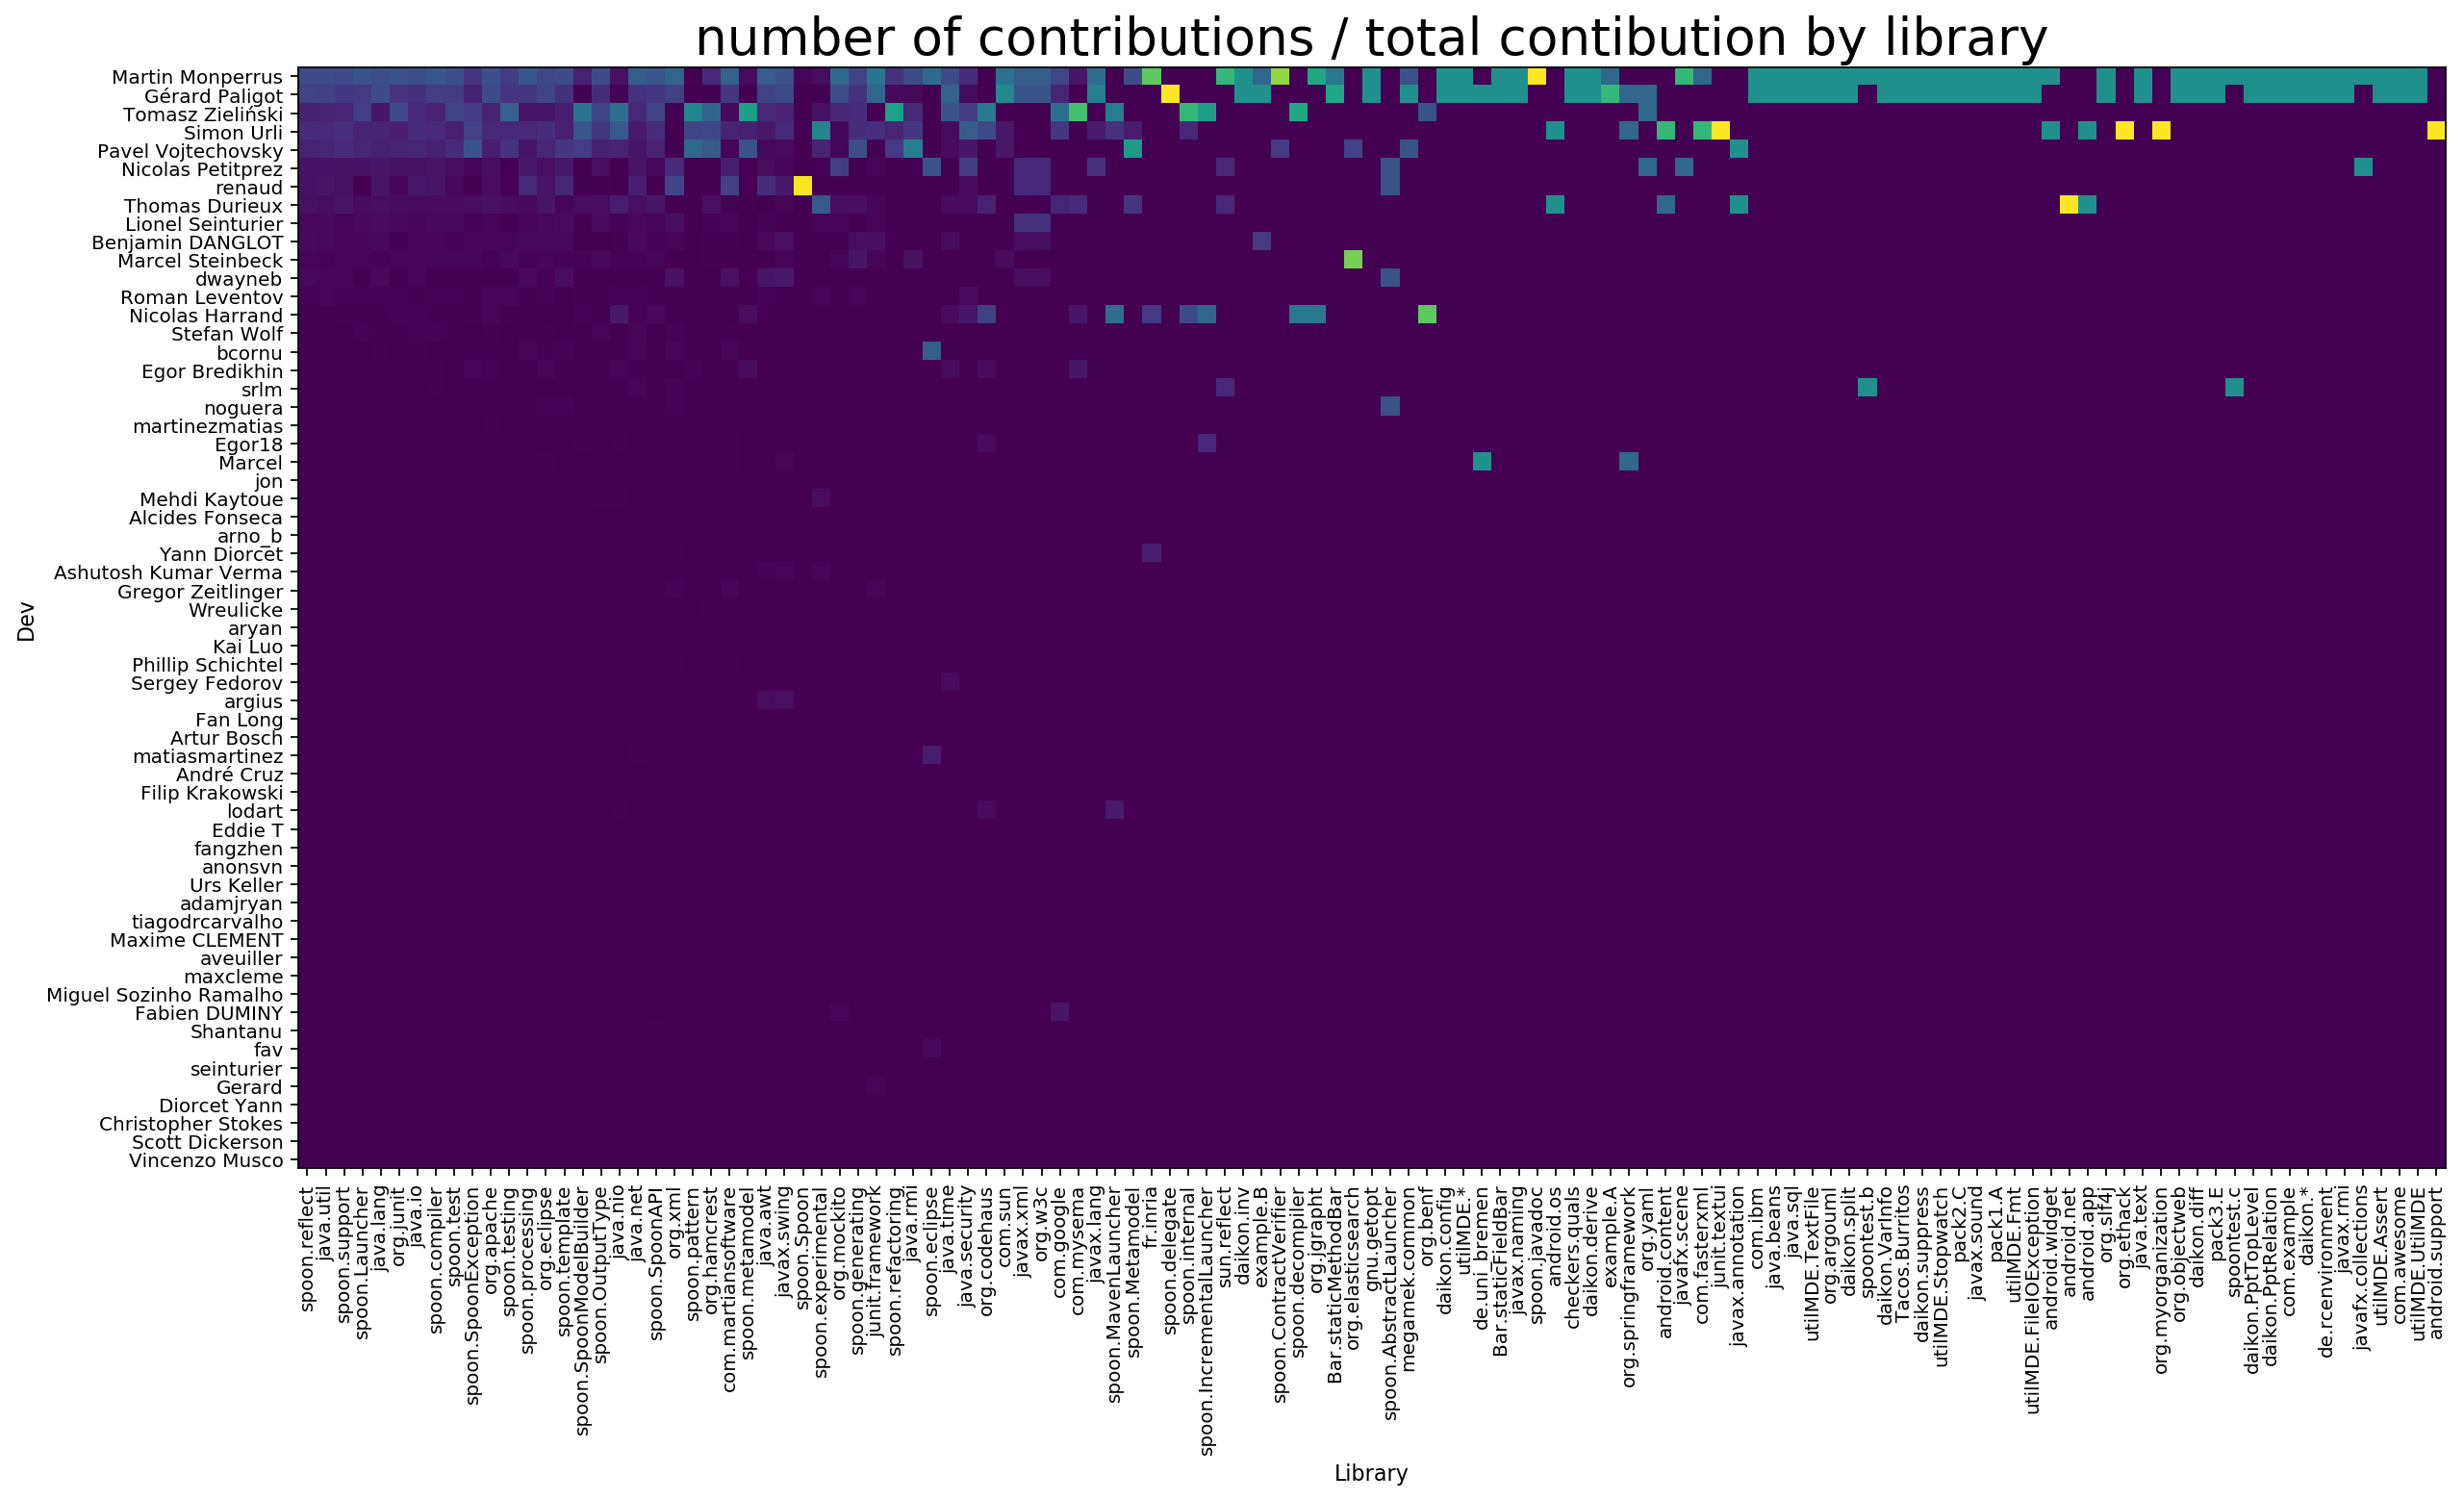

In [14]:
plot_matrix(agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1), 'number of contributions / total contibution by library', xlabel='Library', ylabel='Dev')

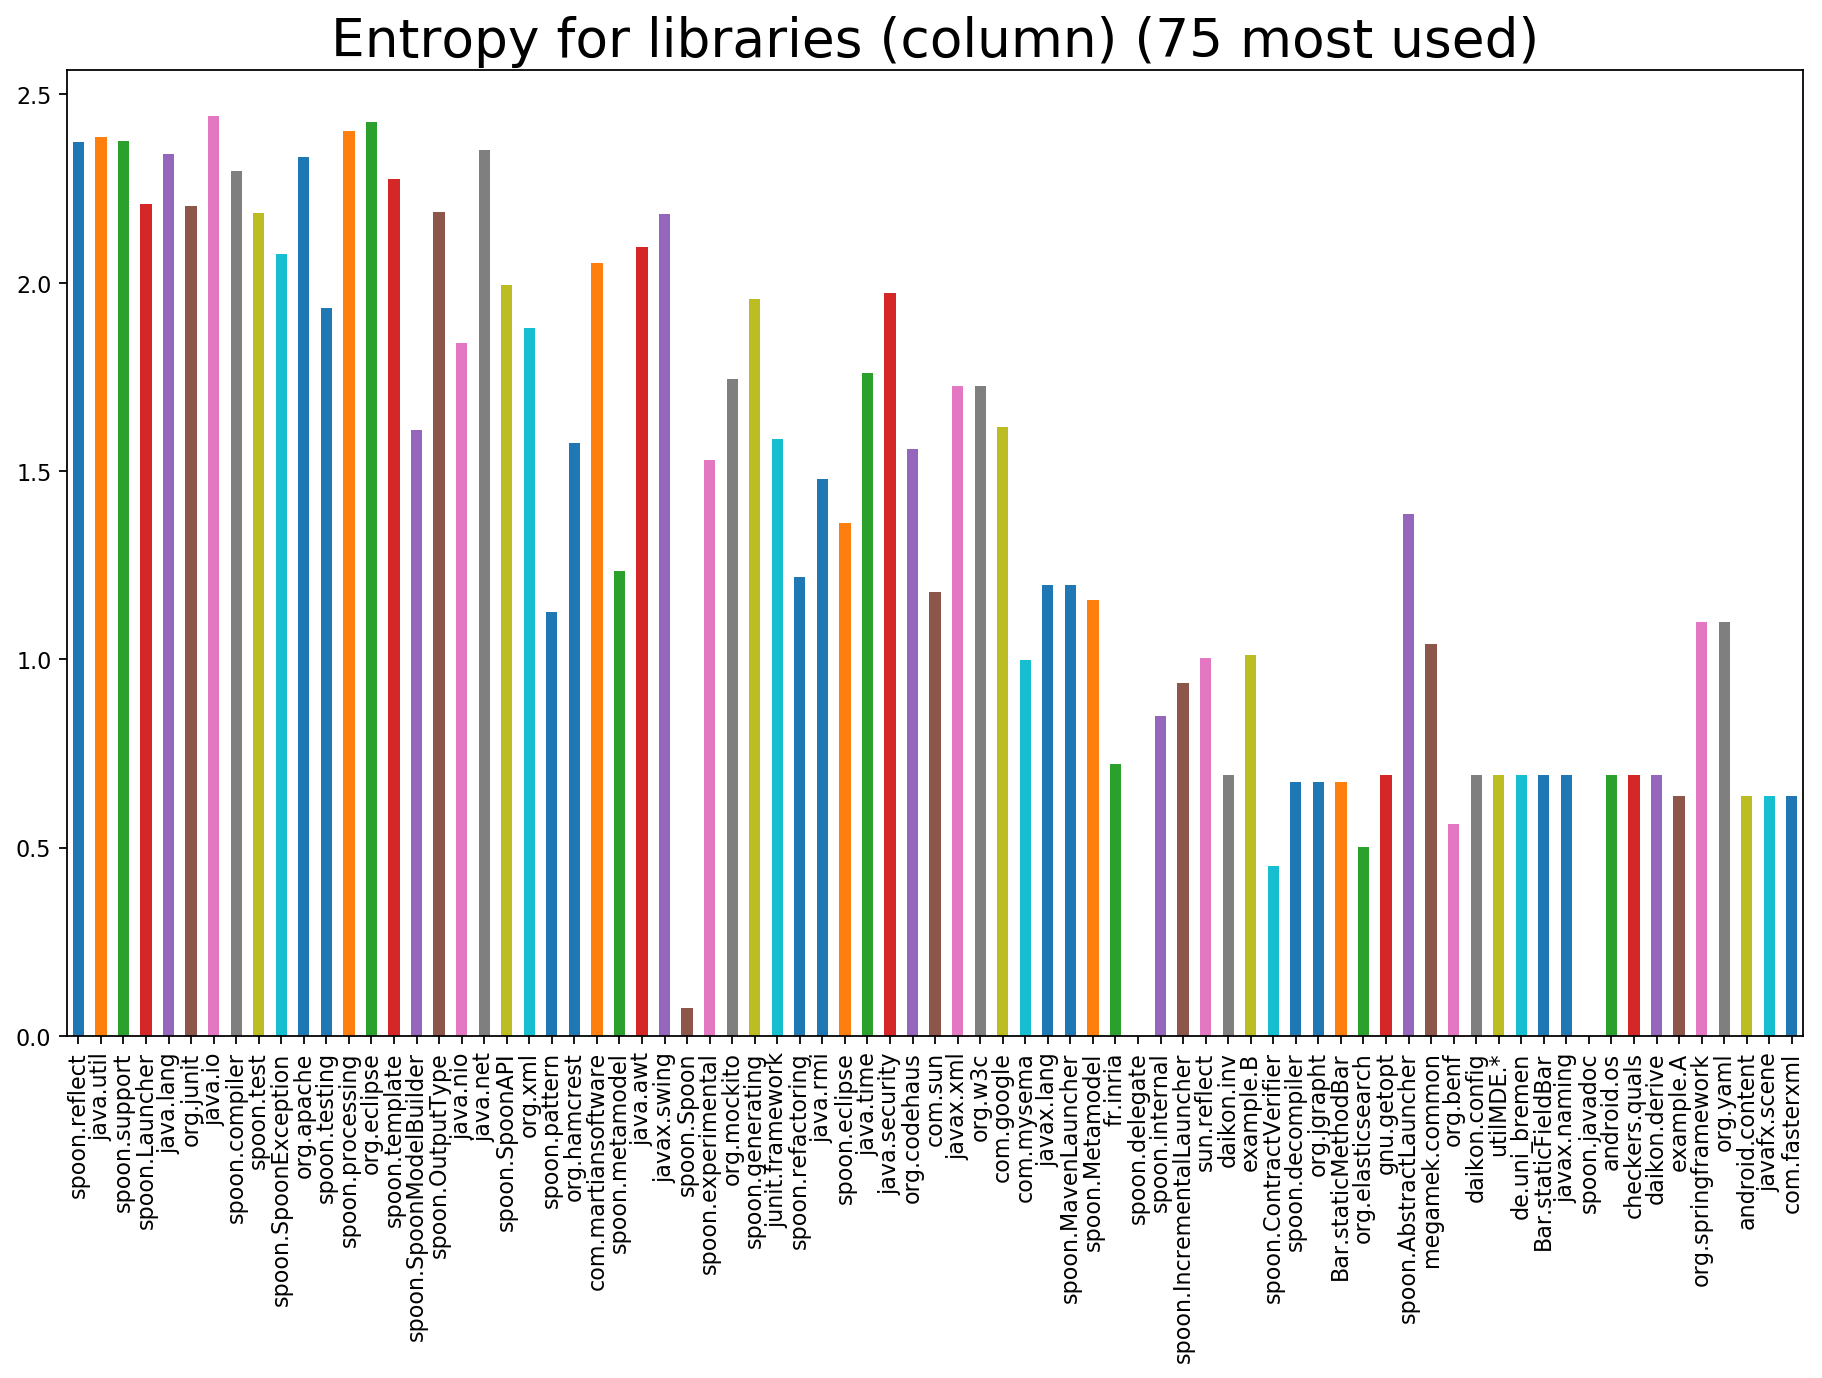

In [15]:
from scipy.stats import entropy

fig = plt.figure(figsize=(14, 8), dpi=160, facecolor='w', edgecolor='k')
#agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1))), 0).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 0).iloc[:77].plot.bar()
plt.title('Entropy for libraries (column) (75 most used)', fontsize=24)
plt.show()

Some libraries seam to contain more information than others, such as spoon.Launcher, junit.testing, org.xml, spoon.metatmodel, spoon.patttern, java.rmi, spoon.refactoring and spoon.eclipse.

Mostly it is spoon.* imports or testing import.

spoon.Spoon has been imported by very few users. Infact this must be a former package that has disappeared since then.

In [16]:
agreg_sorted['spoon.Spoon'].sort_values(ascending=False).head()

author
renaud                  71
Martin Monperrus         1
bcornu                   0
Ashutosh Kumar Verma     0
Yann Diorcet             0
Name: spoon.Spoon, dtype: int64

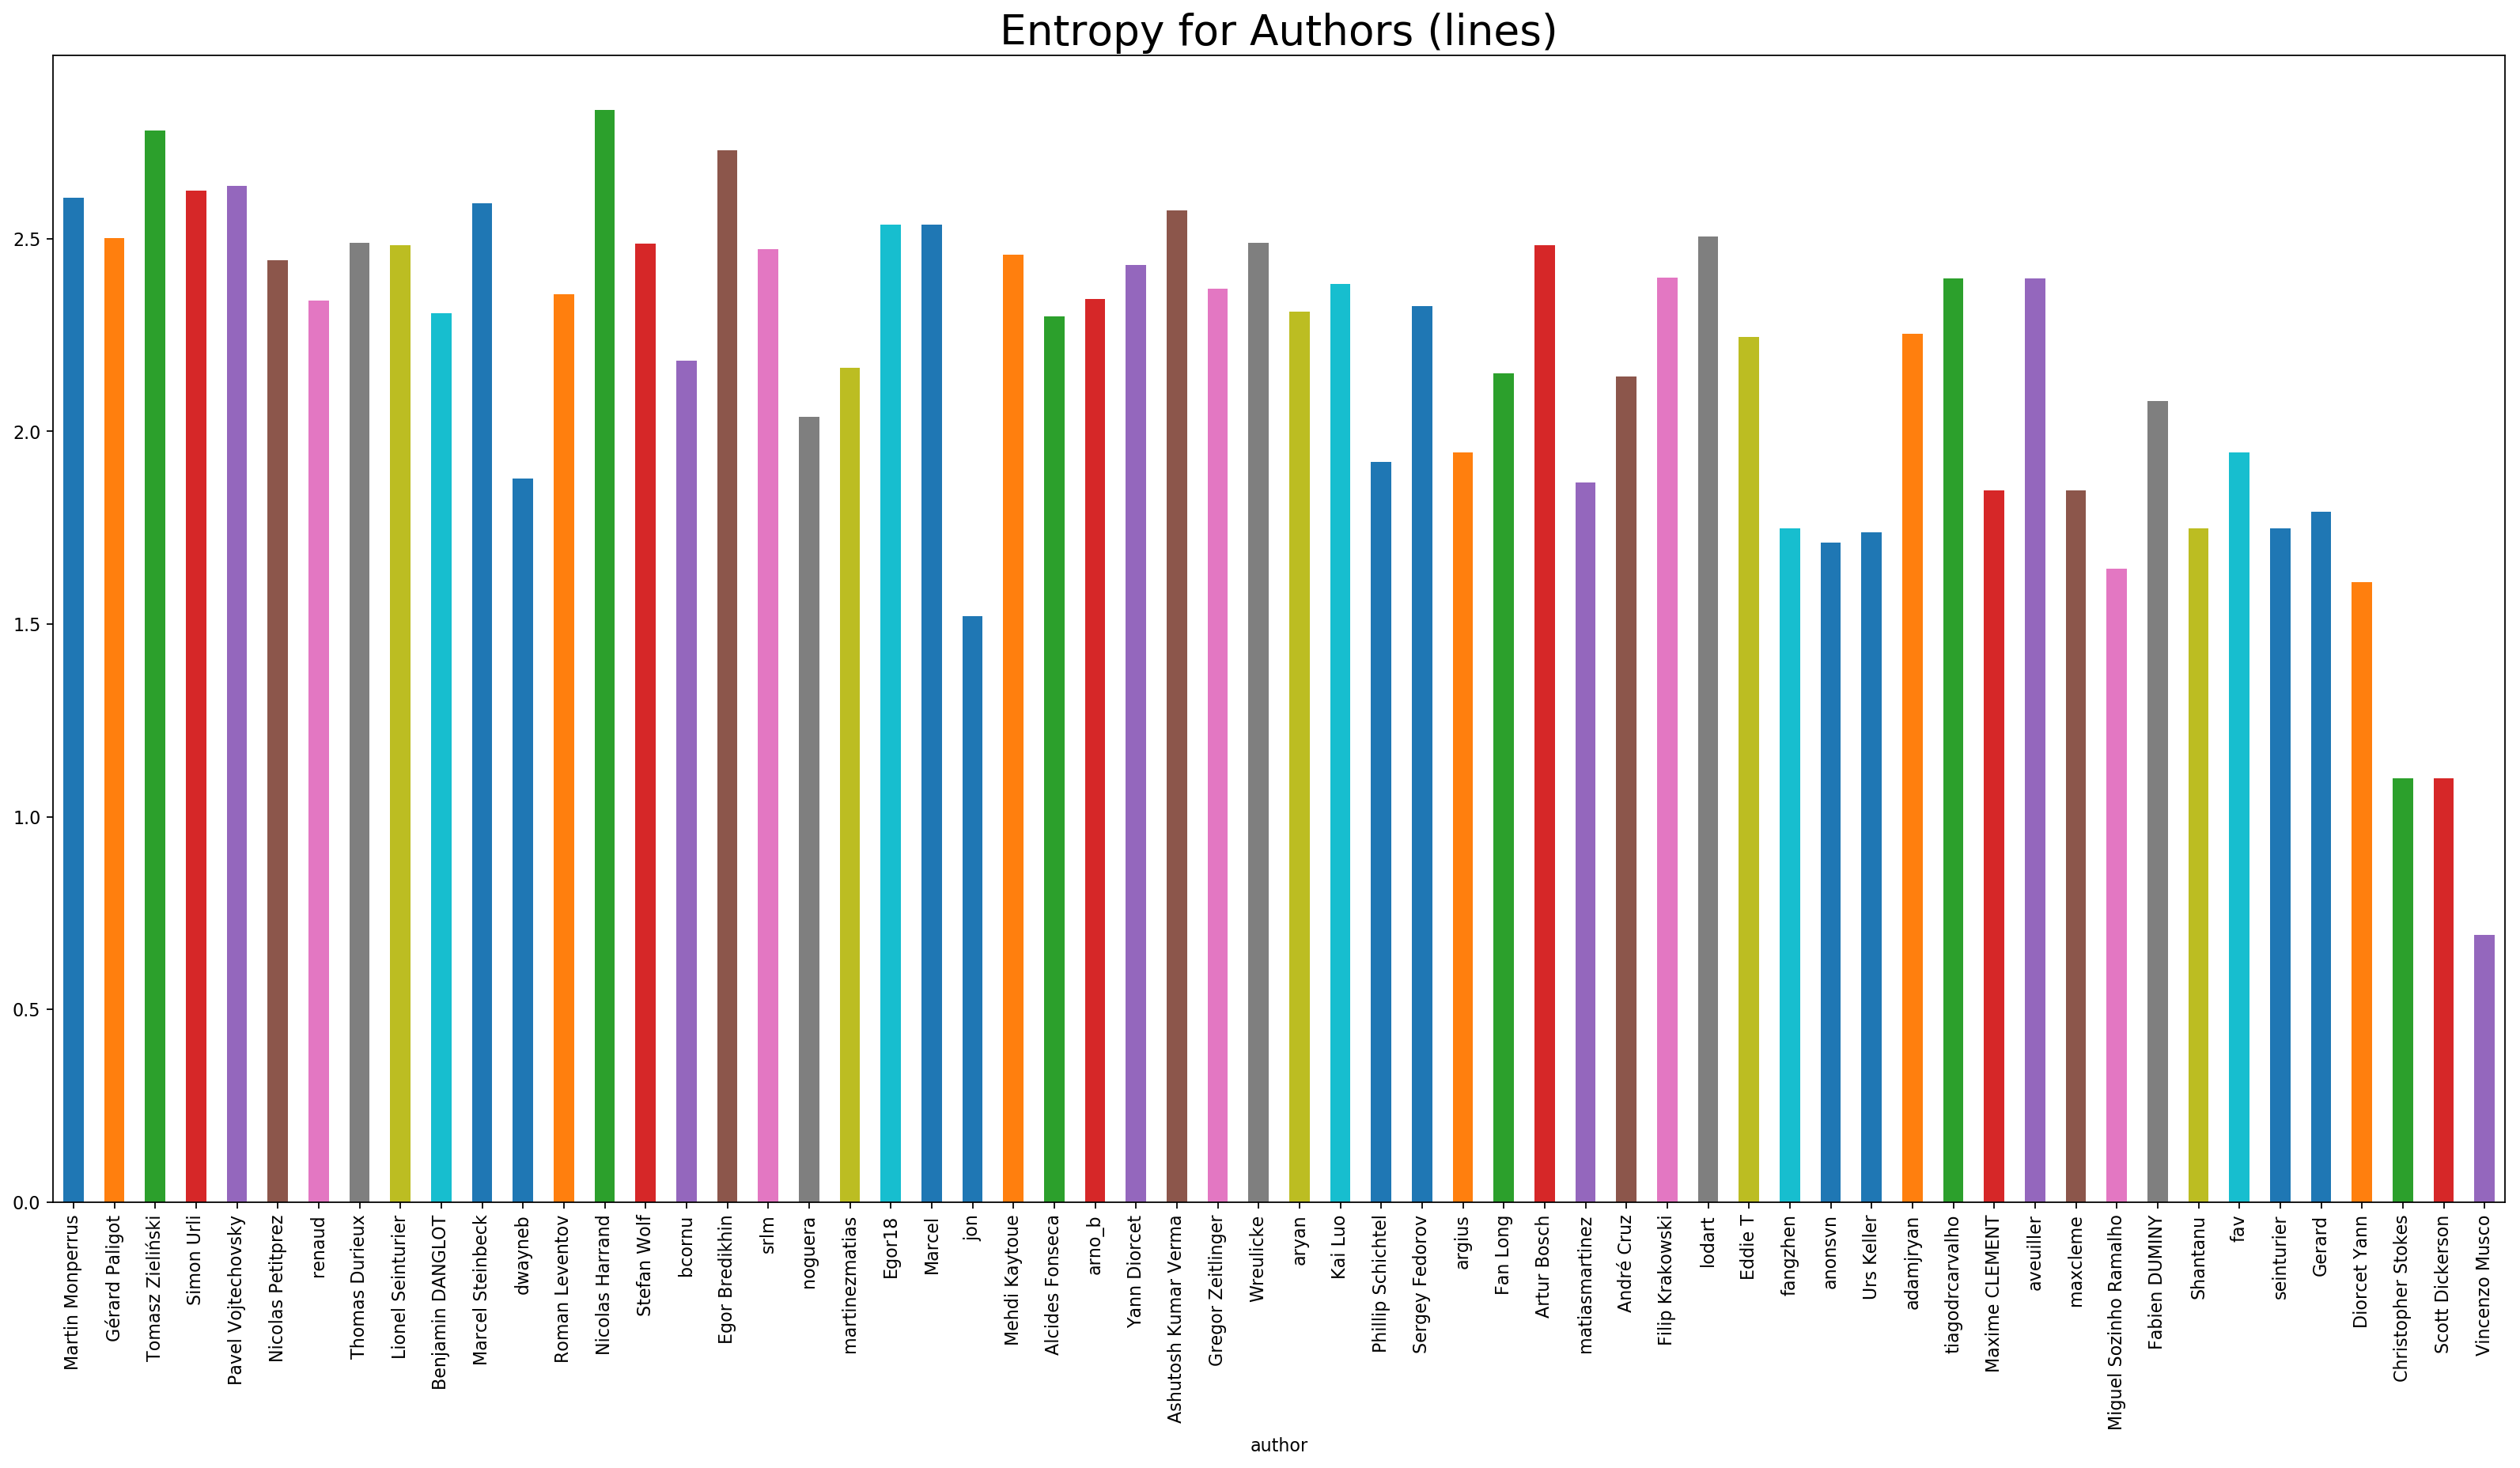

In [17]:
fig = plt.figure(figsize=(25, 12), dpi=160, facecolor='w', edgecolor='k')
# agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1)))), 1).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).plot.bar()
plt.title('Entropy for Authors (lines)', fontsize=24)
plt.show()

Who is renaud and what is spoon.Spoon ? 
And who is Jon ? 

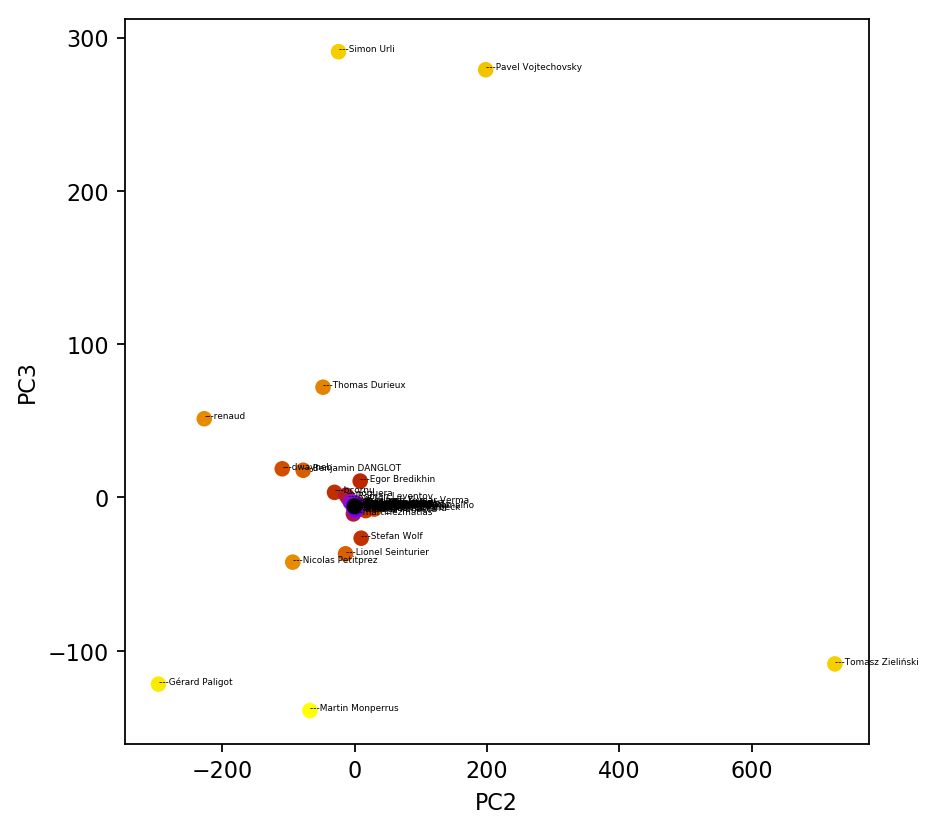

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(agreg_sorted)

principalDf = pd.DataFrame(data = principalComponents, index = ratio_libcontrib_totcontrib.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

def quick_pca_plot(df, pc1, pc2, labels=False, c=None):
    fig = plt.figure(figsize=(6, 6), dpi=160, facecolor='w', edgecolor='k')
    plt.scatter(df.iloc[:,pc1], df.iloc[:,pc2], cmap='gnuplot', c=c)
    if labels:
        for index, line in df.iterrows():
            plt.text(line.iloc[pc1], line.iloc[pc2], f'---{index}', fontsize=4)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    
    plt.show()

quick_pca_plot(principalDf, 1, 2, labels=True, c=np.log(number_of_contibs))

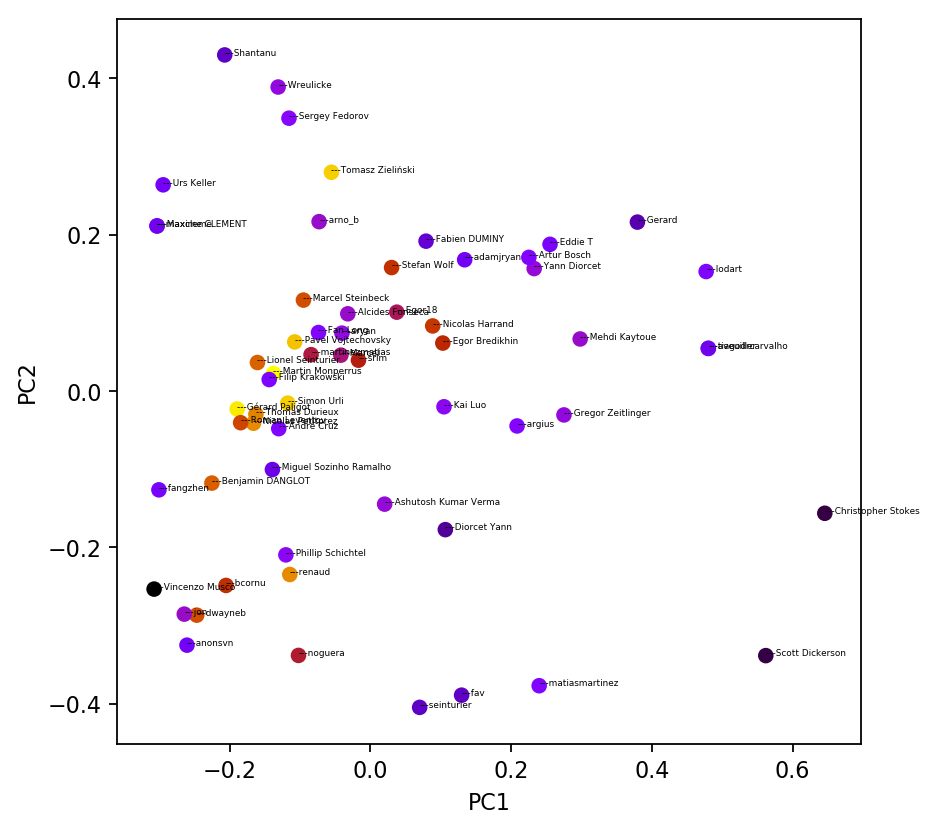

In [19]:
agreg_normalized = agreg_sorted.div(np.sqrt(agreg_sorted.pow(2).sum(axis=1)), axis=0)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(agreg_normalized)

principalDf = pd.DataFrame(data = principalComponents, index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log(number_of_contibs))

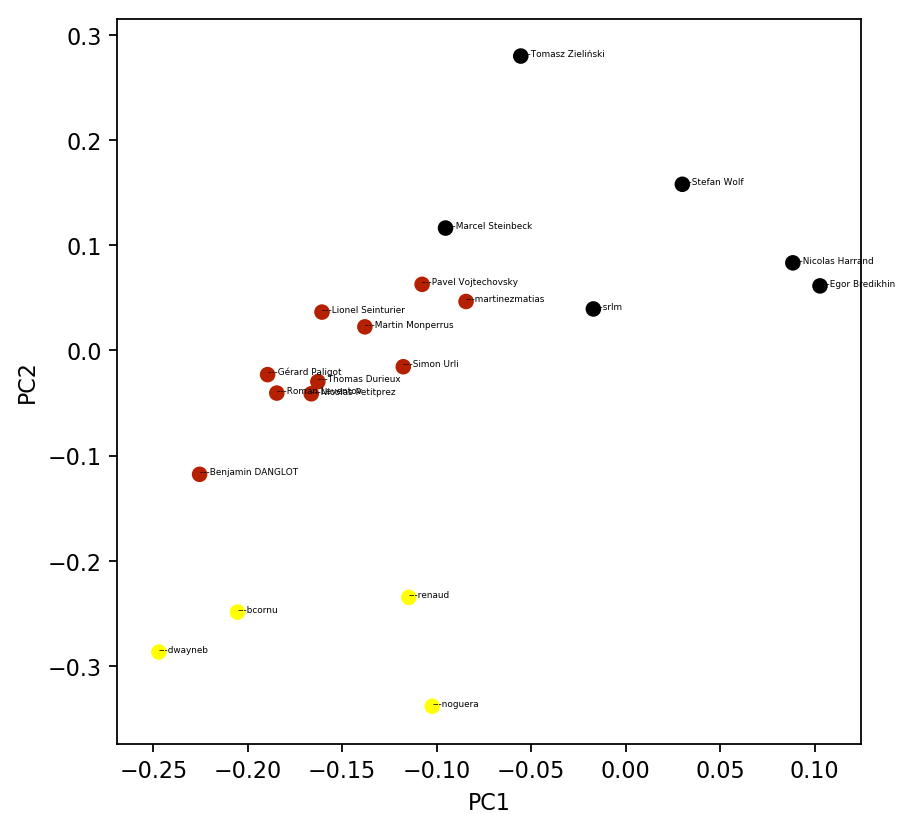

In [20]:
from sklearn.cluster import KMeans

top = principalDf.loc[number_of_contibs > 100]

kmeans = KMeans(n_clusters=3, n_init=10, random_state=100).fit(top)

y_kmeans = kmeans.predict(top)

quick_pca_plot(top , 0, 1, labels=True, c=y_kmeans)

In [21]:
top

principal component 1  principal component 2
author                                                          
Martin Monperrus                -0.138028               0.022455
Gérard Paligot                  -0.189499              -0.022969
Tomasz Zieliński                -0.055533               0.279939
Simon Urli                      -0.117698              -0.015466
Pavel Vojtechovsky              -0.107740               0.062878
Nicolas Petitprez               -0.166393              -0.041174
renaud                          -0.114760              -0.234747
Thomas Durieux                  -0.162905              -0.029666
Lionel Seinturier               -0.160725               0.036495
Benjamin DANGLOT                -0.225486              -0.117763
Marcel Steinbeck                -0.095345               0.116392
dwayneb                         -0.247029              -0.286747
Roman Leventov                  -0.184636              -0.040499
Nicolas Harrand                  0.088447               0.083318
Stefan Wolf                      0.029971               0.158013
bcornu                          -0.205400              -0.248757
Egor Bredikhin                   0.102819               0.061405
srlm                            -0.017105               0.039484
noguera                         -0.102374              -0.338291
martinezmatias                  -0.084488               0.046567

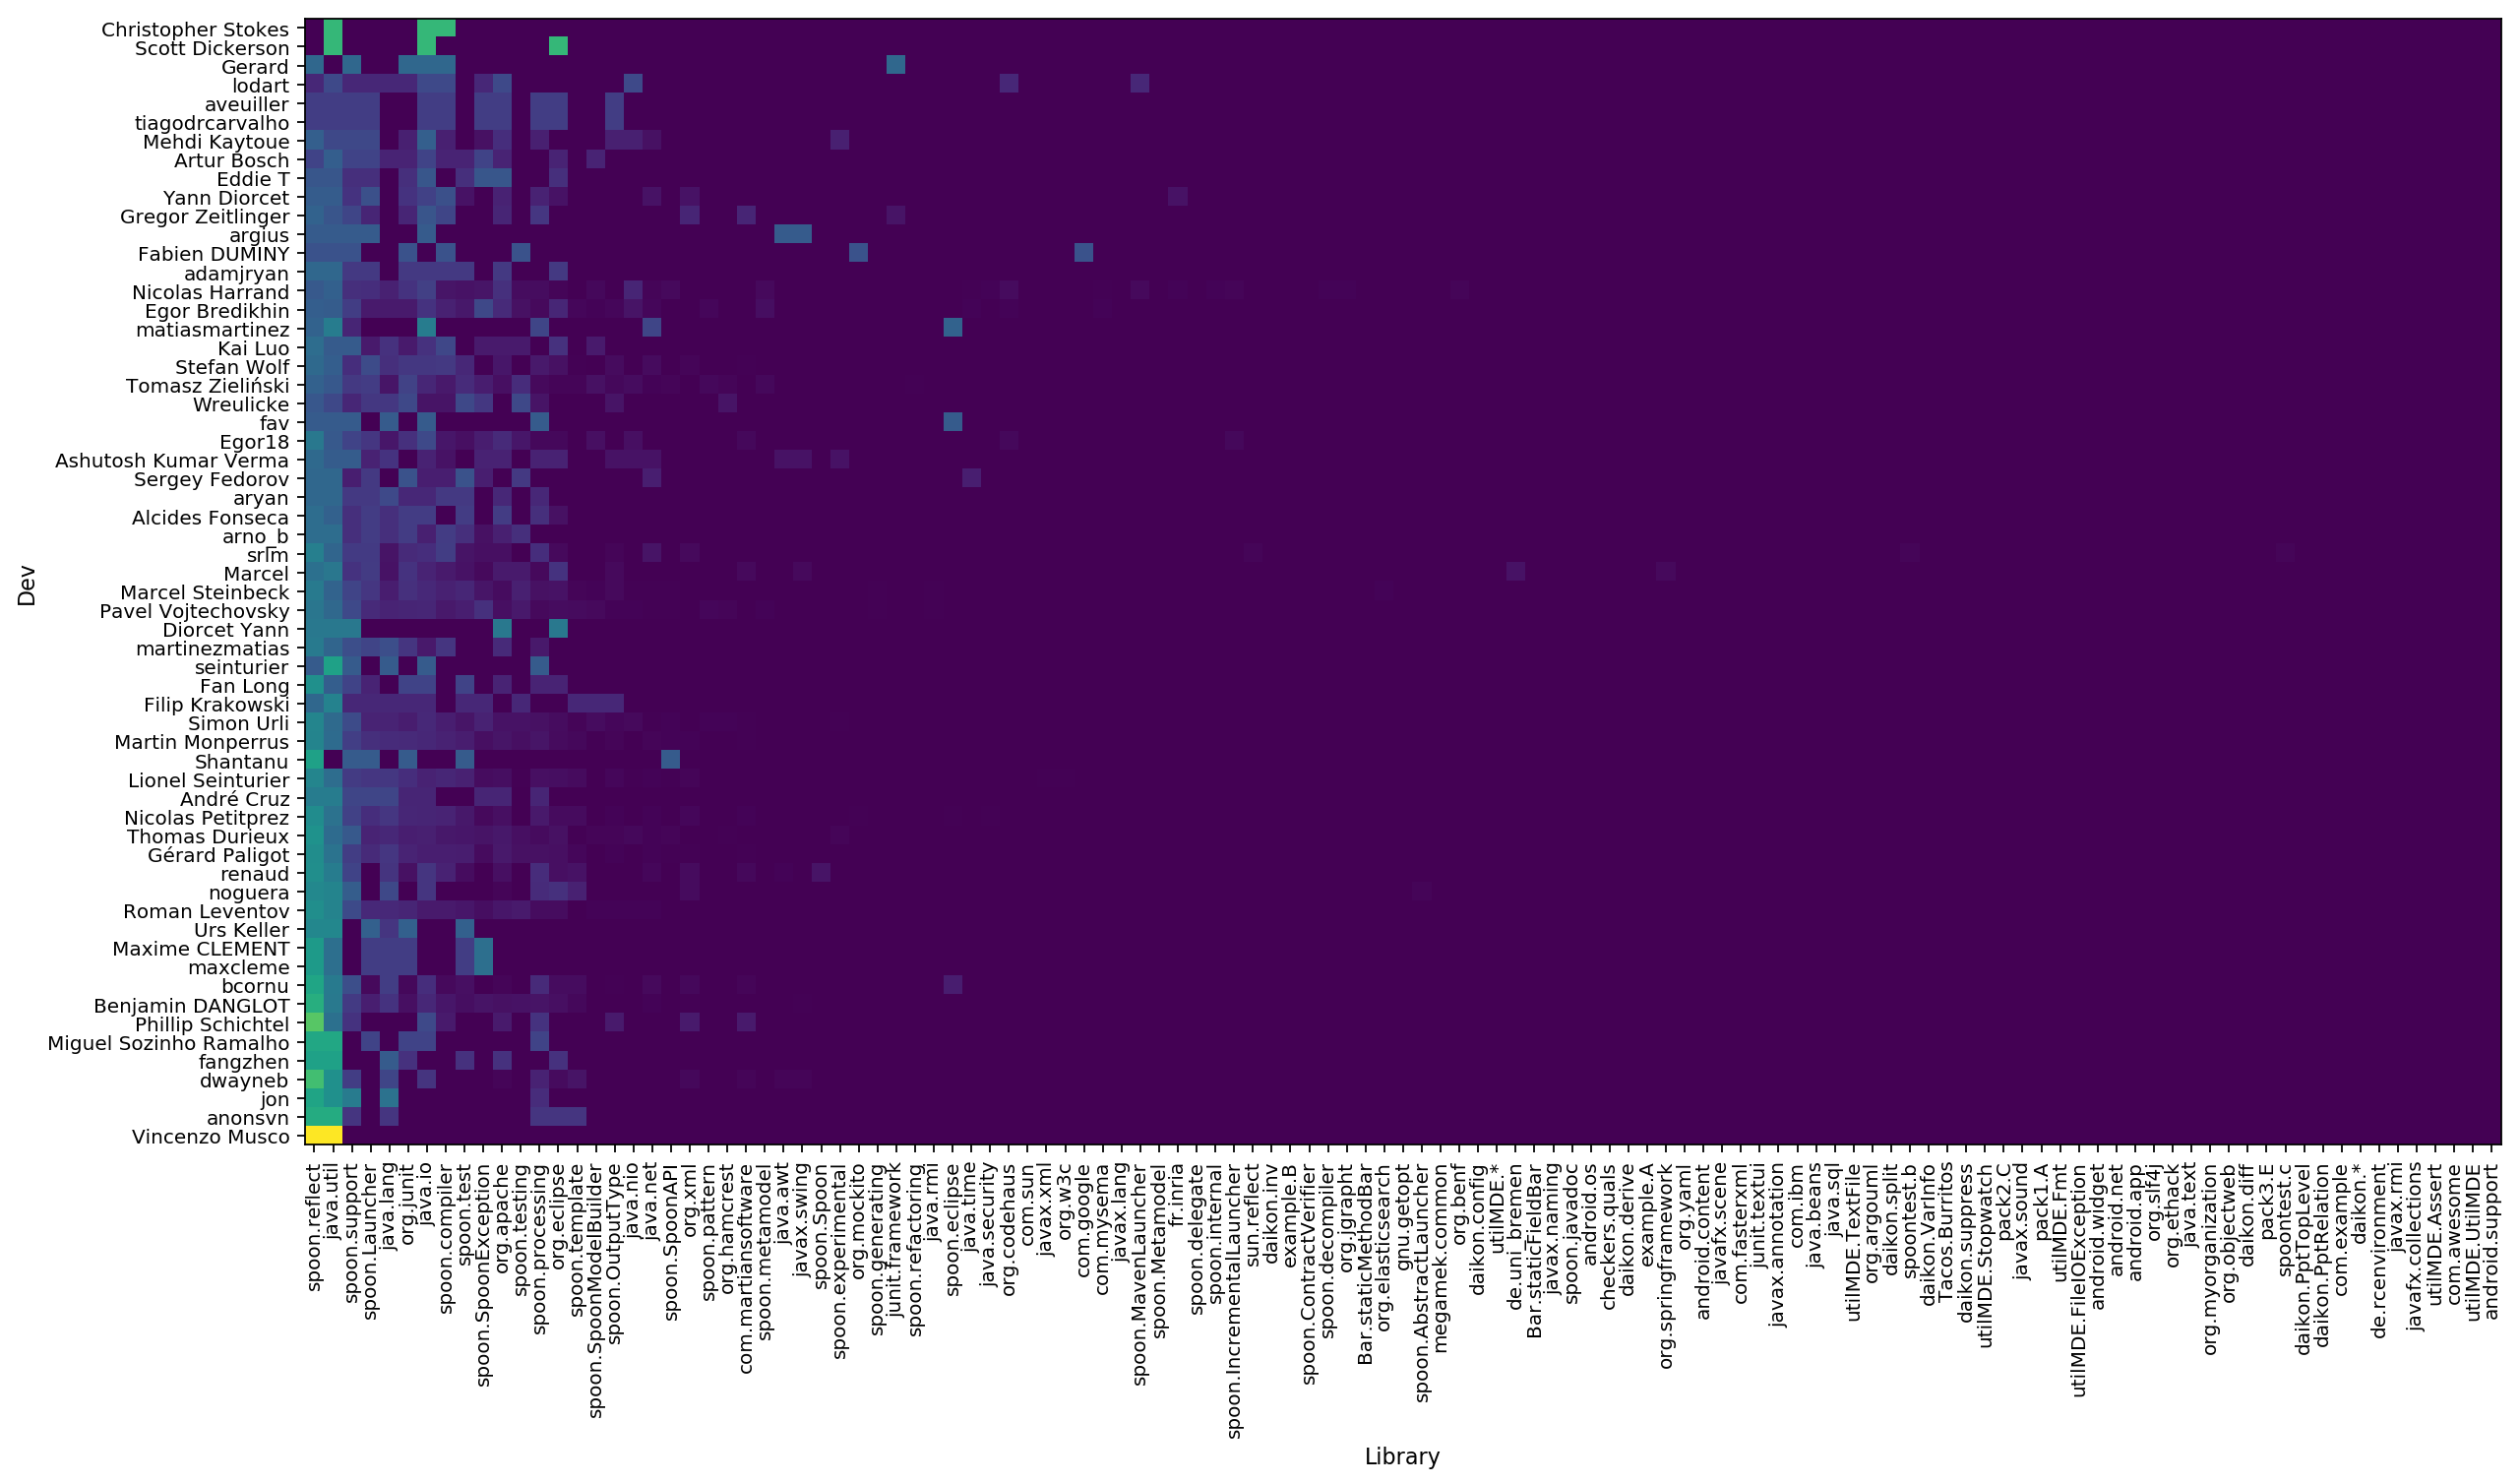

In [22]:
ratio_libcontrib_totcontrib
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(ratio_libcontrib_totcontrib)
principalDf = pd.DataFrame(data = principalComponents, index = ratio_libcontrib_totcontrib.index
             , columns = ['PC1'])
plot_matrix(ratio_libcontrib_totcontrib.loc[principalDf.sort_values(by='PC1').index], '', xlabel='Library', ylabel='Dev')

# DEV / PACKAGE

In [23]:
from functools import reduce
#mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, 2)
packages_set = list(reduce(lambda x,y: x|y,[ 
    set([ file['package'] for file in commit['files_info'].values()])
    for commit in commit_info.values()
]))
packages_set.remove('')
packages_set.remove('app')
package_mapping, package_mapping_elemnts, package_mapping_size = define_mapping(packages_set, 3)

In [24]:
data = []
for sha, commit in list(commit_info.items()):
    packages = set()
    c = z_k(package_mapping_size)
    for file, file_info in commit['files_info'].items():
        file_packages = set([package_mapping(file_info['package'])])
        packages = packages | file_packages
        c = v_sum(c, z_k(package_mapping_size, *file_packages))
    if len(libraries) > 0:
        data.append( [sha, commit['author']['name']] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df_packages = pd.DataFrame(data=data, columns=['sha', 'author', *package_mapping_elemnts])

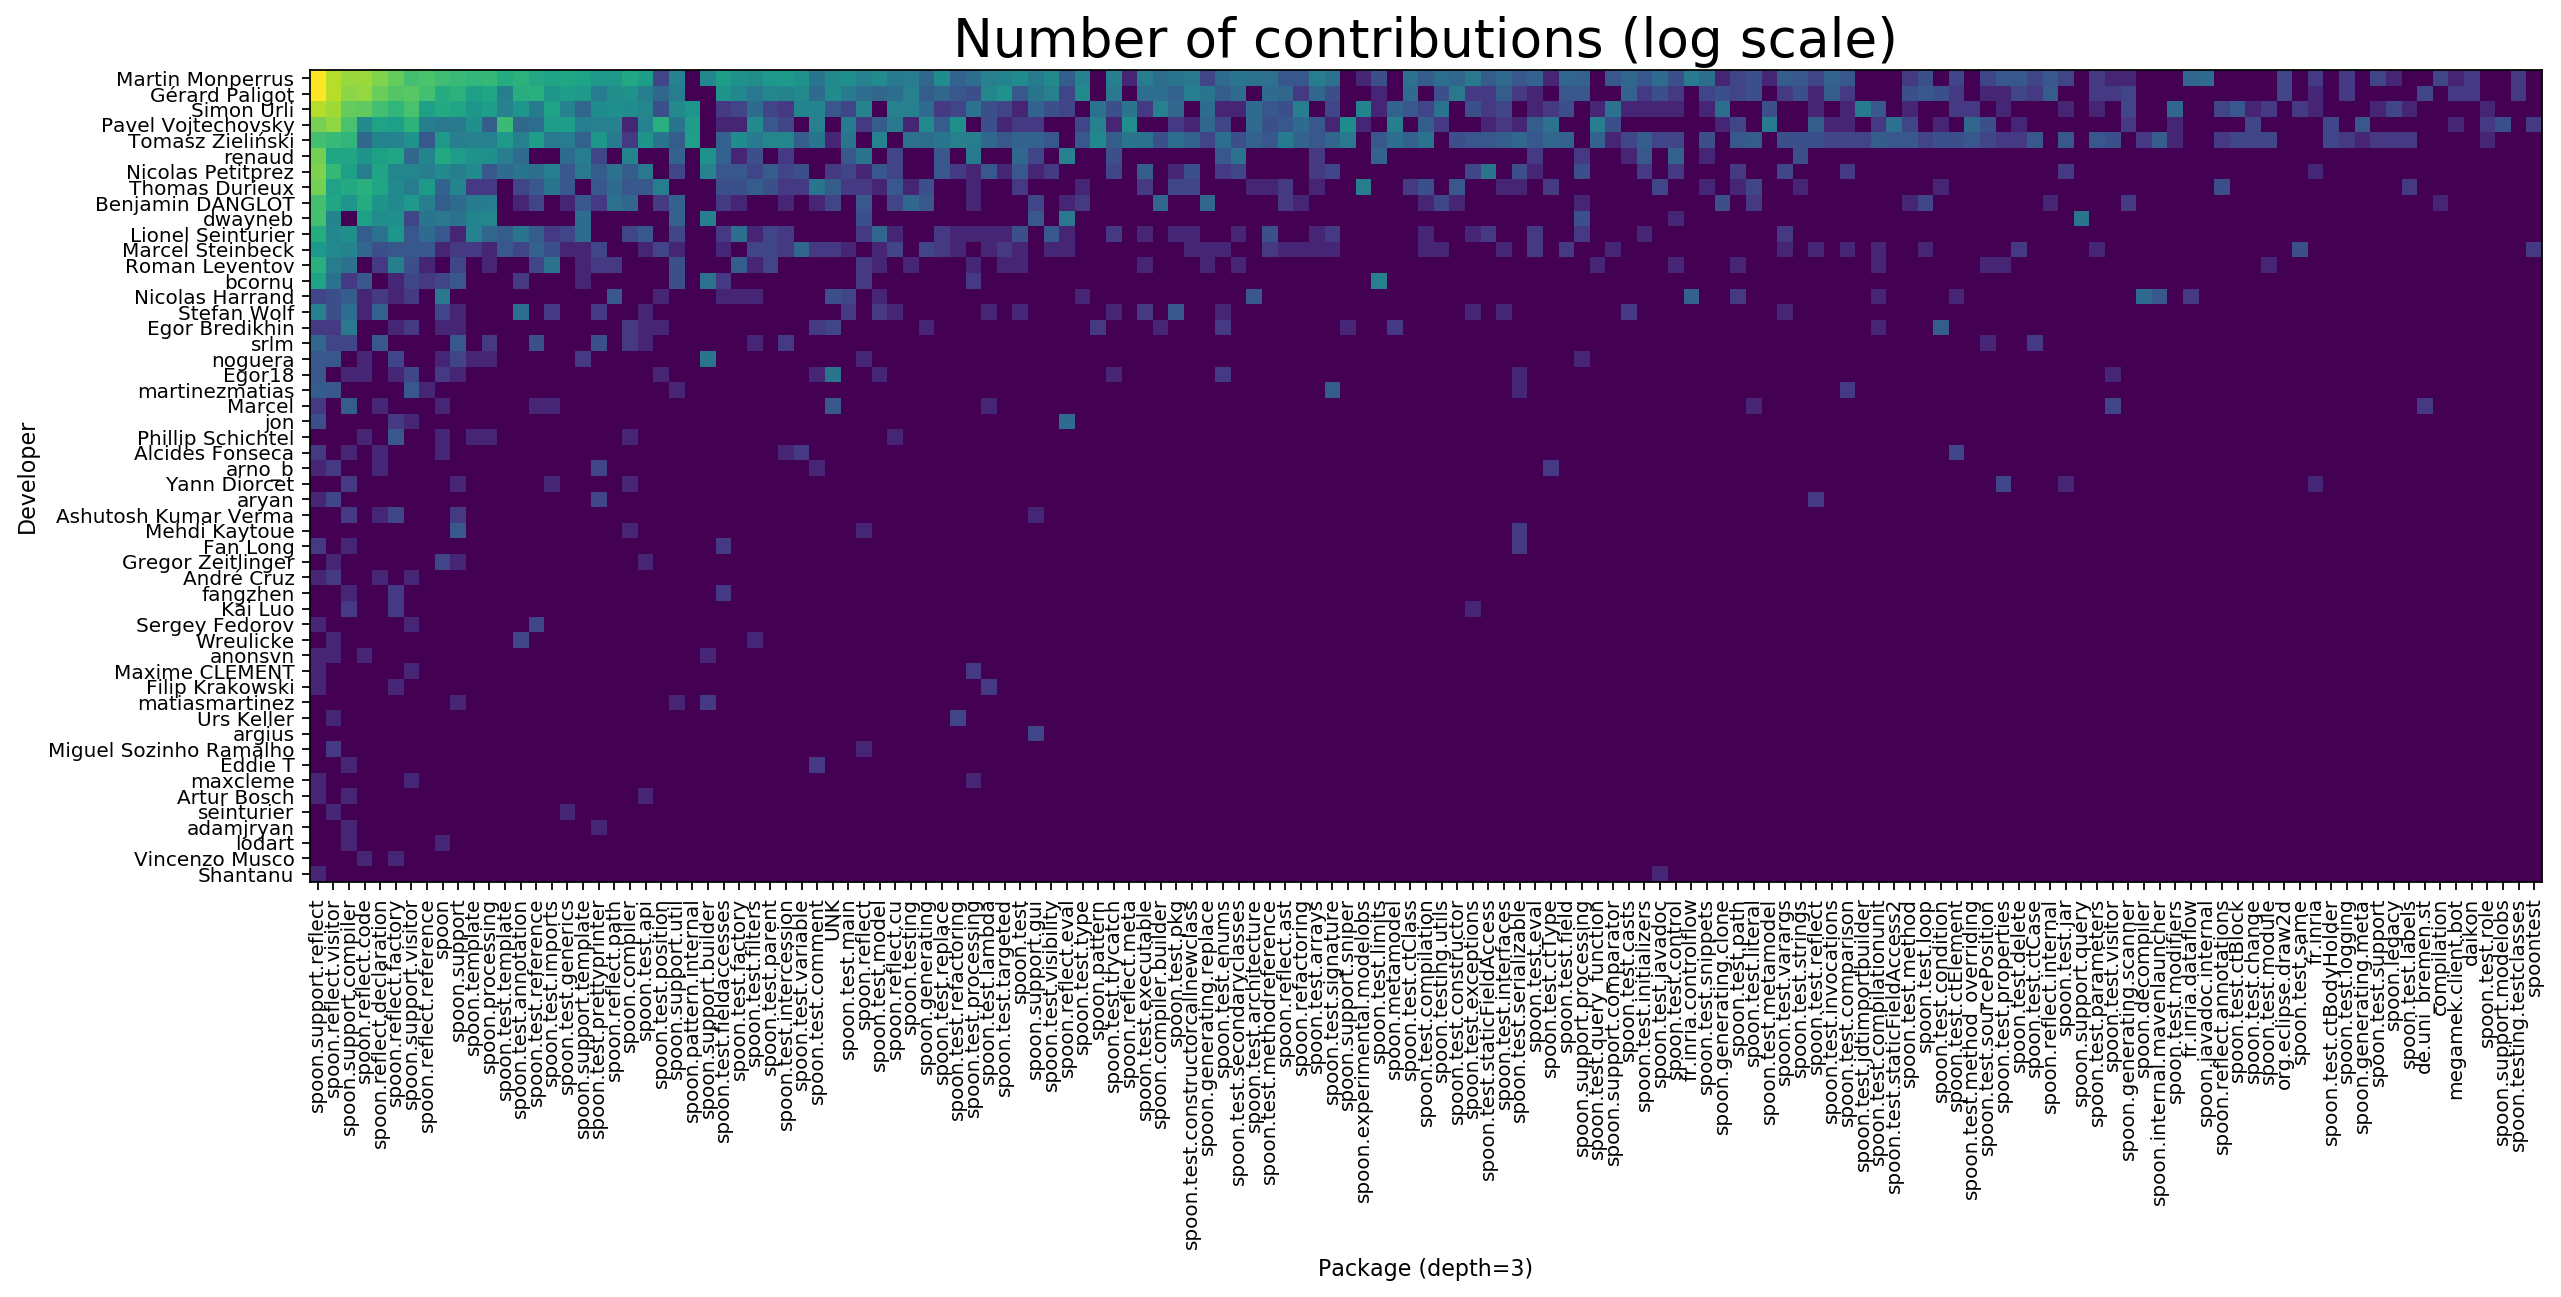

In [25]:
agreg_packages = df_packages.groupby('author').sum()
agreg_packages = group_duplicate_entry(agreg_packages, *duplicate_entries)
agreg_packages = agreg_packages.loc[agreg_packages.sum(axis=1) > 1]
agreg_packages = agreg_packages.loc[:,agreg_packages.sum() > 3]

agreg_packages_sorted = agreg_packages.loc[agreg_packages.sum(axis=1).sort_values(ascending=False).index]
agreg_packages_sorted = agreg_packages_sorted.loc[:,agreg_packages_sorted.sum(axis=0).sort_values(ascending=False).index]
plot_matrix(agreg_packages_sorted, 'Number of contributions (log scale)', xlabel='Package (depth=3)', ylabel='Developer', log_scale=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


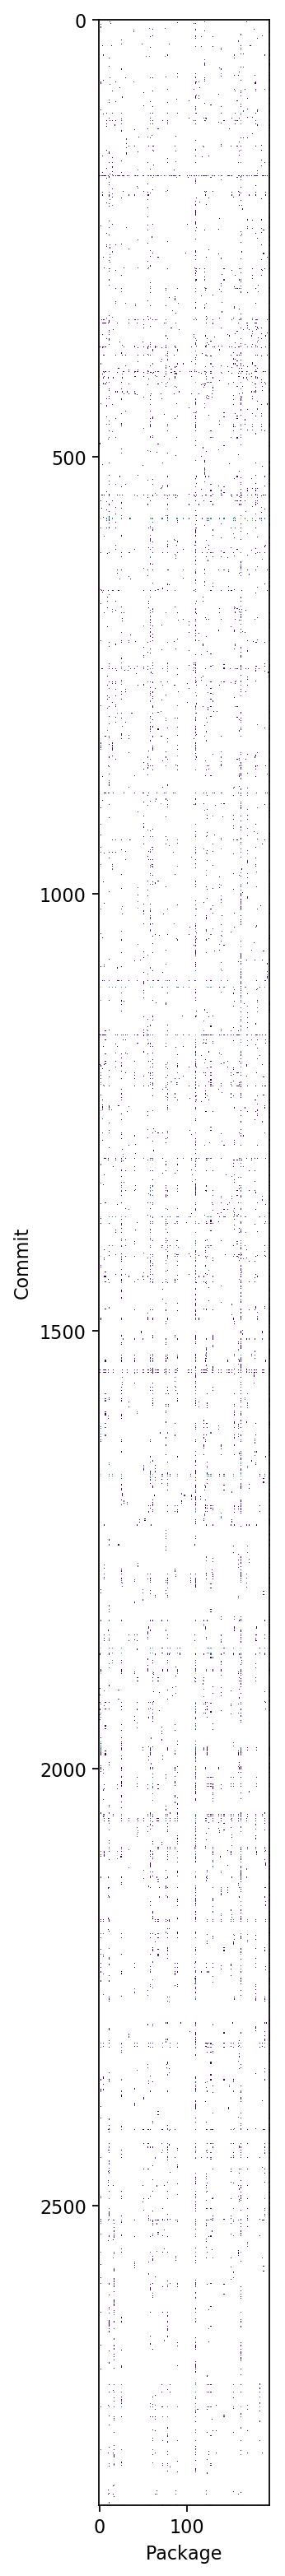

In [26]:
df_packages_commits = df_packages.iloc[:,2:]

fig = plt.figure(figsize=(4, 25), dpi=160, facecolor='w', edgecolor='k')
plt.imshow(np.log(df_packages_commits.add(0)))
plt.ylabel('Commit')
plt.xlabel('Package')
plt.show()